# Machine Learning - differentiate red and white wine

* Only very basic cleaning: 
  * keep all the outliers
    * why? no need to remove them to distinguish between red and white wine
  * Which quantities to keep?
    * only drop quality, because that does not make sense
    * check out ANOVA for all quantities: groups red, white
* compare models (accuracy, precision, recall, F1-score)
  * logistic regression
  *  random forest
* Is there a better model?

In [1]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

In [2]:
%run ../src/constants.py

In [3]:
wine = pd.read_parquet('../data/processed/wine.parquet')

wine.head()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit,input_outlier_count
0,3.51,7.4,0.70,0.00,0.076,34.0,11.0,0.56,1.9,0.9978,9.4,5,red,low,False,False,0
1,3.20,7.8,0.88,0.00,0.098,67.0,25.0,0.68,2.6,0.9968,9.8,5,red,low,False,False,0
2,3.26,7.8,0.76,0.04,0.092,54.0,15.0,0.65,2.3,0.9970,9.8,5,red,low,False,False,0
3,3.16,11.2,0.28,0.56,0.075,60.0,17.0,0.58,1.9,0.9980,9.8,6,red,medium,False,False,0
5,3.51,7.4,0.66,0.00,0.075,40.0,13.0,0.56,1.8,0.9978,9.4,5,red,low,False,False,0


# Prepare the data

## Config Data Prep

In [4]:
do_step = {
    'drop_outliers' : False, # estimation is getting worse
    'drop_features' : False, # drop weakly related features to color
    'undersample' : False,
    'oversample'  : False
}

## Additional Data Cleaning
- Drop 

In [5]:
# drop the outliers
# TODO check the outliers
if do_step['drop_outliers']:
    wine = wine[wine.input_outlier_count > 0]
wine = wine.drop(columns='input_outlier_count')

In [6]:
# from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# # LabelEncoder
# le = LabelEncoder()
# wine['color'] = le.fit_transform(wine['color'])

## Feature Selection - Dimensionality Reduction

### Remove non-related quantities

In [7]:
# drop not columns that are not related to white or red wine from domain knowledge
wine = wine.drop(columns=[
    'quality',
    'quality_label',
    'total_sulfur_dioxide_above_eu_limit', 
    'volatile_acid_above_eu_limit'
    ])

### ANOVA Analysis
Which Feature could be removed?

In [8]:
# ANOVA Test to see the in the input variables concerning wine type
# Problem: Data is not normally distributed!
from pandas.api.types import is_numeric_dtype

anova_tests = []
for quantity in all_inputs:
    if is_numeric_dtype(wine[quantity]):
        anova_test = wine.anova(dv=quantity, between='color').rename(index={0:quantity})
        anova_tests.append(anova_test)

anova_tests = pd.concat(anova_tests, axis=0)
anova_tests = anova_tests.sort_values('F')
anova_tests

,Source,ddof1,ddof2,F,p-unc,np2
alcohol,color,1,5318,17.799023,2.495934e-05,0.003336
citric_acid,color,1,5318,185.850548,1.272721e-41,0.033767
ph,color,1,5318,569.110998,1.381789e-119,0.096671
residual_sugar,color,1,5318,644.153170,3.086586e-134,0.108040
density,color,1,5318,1202.070683,1.185189e-237,0.184365
free_sulfur_dioxide,color,1,5318,1469.737381,3.792741e-284,0.216528
fixed_acidity,color,1,5318,1646.761391,6.745890e-314,0.236442
sulphates,color,1,5318,1683.576206,5.462390e-320,0.240457
chlorides,color,1,5318,1768.104886,0.000000e+00,0.249517
volatile_acidity,color,1,5318,3795.296863,0.000000e+00,0.416457


In [9]:
# Welch ANOVA Test to see the in the input variables concerning wine type
from pandas.api.types import is_numeric_dtype

wanova_tests = []
for quantity in all_inputs:
    if is_numeric_dtype(wine[quantity]):
        wanova_test = wine.welch_anova(dv=quantity, between='color').rename(index={0:quantity})
        wanova_tests.append(wanova_test)

wanova_tests = pd.concat(wanova_tests, axis=0)
wanova_tests.sort_values('F')

,Source,ddof1,ddof2,F,p-unc,np2
alcohol,color,1,2623.254441,19.960957,8.238914e-06,0.003336
citric_acid,color,1,1737.205776,120.426612,3.879756e-27,0.033767
ph,color,1,2309.193827,556.572665,1.980028e-110,0.096671
fixed_acidity,color,1,1596.004755,898.229968,6.116198e-157,0.236442
chlorides,color,1,1566.627064,924.115814,6.146743e-160,0.249517
sulphates,color,1,1787.467410,1148.125512,8.268530e-195,0.240457
residual_sugar,color,1,5179.361441,1572.834277,1.289608e-300,0.108040
density,color,1,3675.740709,1813.365605,1.926856e-322,0.184365
volatile_acidity,color,1,1665.058550,2265.688605,6.905960e-313,0.416457
free_sulfur_dioxide,color,1,3903.515458,2326.692887,0.000000e+00,0.216528


* p-values
  * extremely small p-values for all quantities, meaning that all means are significantly different from each other
  * this might be due to a large number effect!
* effect size
  * alcohol has a small effect size
  * the rest is medium (0.06) to large (0.14)
* removing outliers
  * F and effect size increase, thus it does not make sense to combine outlier and feature removal. 
* Conclusion: Test if the removal of alcohol would lead to a better classification result

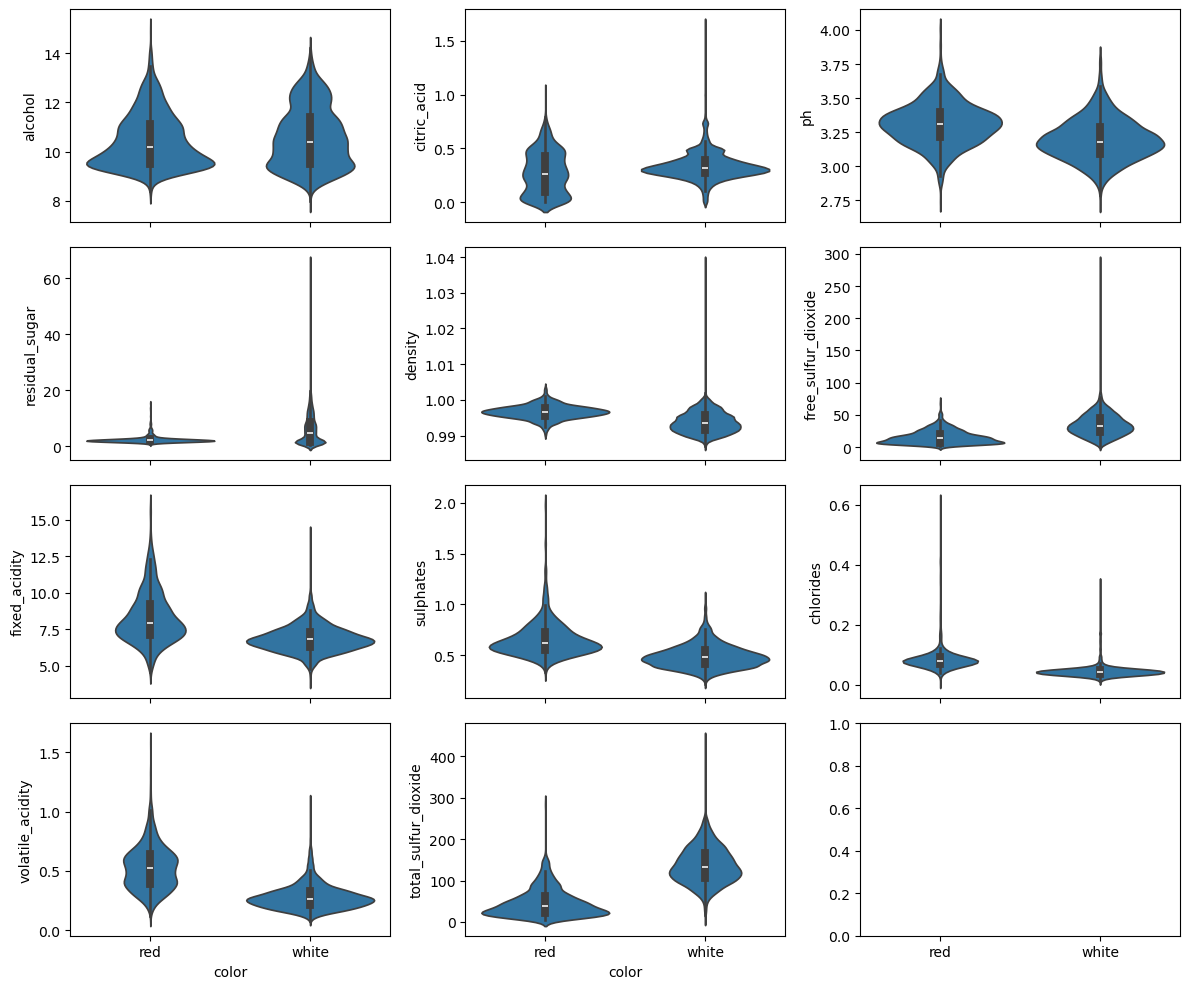

In [10]:
# verify with violin plot (swarmplot too slow!)
fig, ax = plt.subplots(4, 3, figsize=(12, 10), sharex=True)
ax = ax.flatten()

for a, input in zip(ax, anova_tests.index):
    # sns.boxplot(wine, x='color', y=input, ax=a)
    # sns.swarmplot(wine, x='color', y=input, ax=a, size=1)
    sns.violinplot(wine, x='color', y=input, ax=a)

plt.tight_layout()

In [11]:
if do_step['drop_features']:
    wine = wine.drop(columns=[
        'alcohol'
        # ,'citric_acid'
        #,'ph'
        ])

## Data Prep for Modeling

In [12]:
# transform categorical data
wine.color = pd.get_dummies(wine.color).iloc[:,0]
wine = wine.rename(columns={'color':'red'})

## Split Data for Modeling

In [13]:
# define features X and target y
X = wine.drop(columns=['red'])
y = wine['red']

print("original:", wine.shape, "\nX:", X.shape, "\ny:", y.shape)

original: (5320, 12) 
X: (5320, 11) 
y: (5320,)


In [14]:
y.value_counts()

red
False    3961
True     1359
Name: count, dtype: int64

In [27]:
# split test and train data
# TODO where to put the constants?
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.20
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Test data gets about an equal fraction of red and white wines from the full sample:

In [28]:
y_test.value_counts() / y.value_counts()

red
False    0.195658
True     0.212656
Name: count, dtype: float64

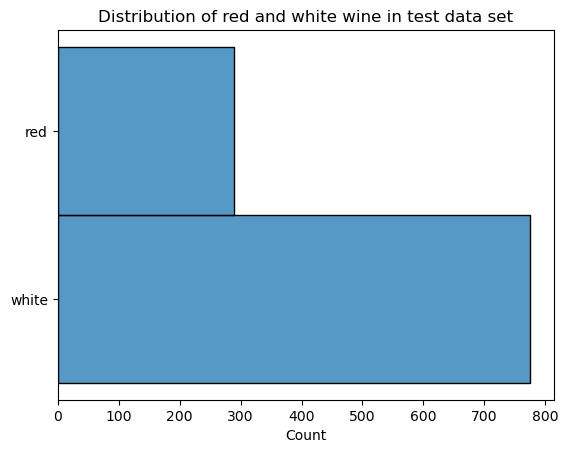

In [29]:
plot = sns.histplot(y=y_test, discrete=True)

plot.set_yticks(ticks=[0, 1], labels=['white', 'red'])
plot.set_ylabel('')
plot.set_title('Distribution of red and white wine in test data set')

plt.show()

## Sampling of Training Data Set

### Under Sampling

In [30]:
UNDERSAMPLING_MAJ_CLASS_FRAC = 0.9

In [31]:
y.value_counts()

red
False    3961
True     1359
Name: count, dtype: int64

In [32]:
# undersampling of majority class!
undersampling_strategy = {
    True : y.sum(),
    False: int(UNDERSAMPLING_MAJ_CLASS_FRAC*(~y).sum())
}

undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=RANDOM_STATE)

if do_step['undersample']:
    X, y = undersample.fit_resample(X, y)

In [33]:
y.value_counts()

red
False    3961
True     1359
Name: count, dtype: int64

### Oversampling of Training Data Set - SMOTE

In [34]:
# transform the dataset
oversample = imblearn.over_sampling.SMOTE()

if do_step['oversample']:
    X, y = oversample.fit_resample(X, y)

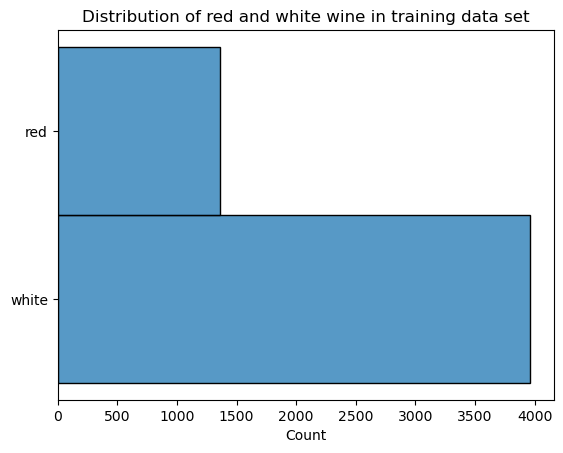

In [35]:
# analyse imbalance
plot = sns.histplot(y=y, discrete=True)

plot.set_yticks(ticks=[0, 1], labels=['white', 'red'])
plot.set_ylabel('')
plot.set_title('Distribution of red and white wine in training data set')

plt.show()

## Features Scaling

In [36]:
# data normalisation with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)

# Logistic Regression

In [37]:
# Train the model
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(max_iter=1000)

# TODO can I run this multiple times? what does that change?
LR_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [38]:
# TODO how to check the model? how to test convergence? which other basic tests should I do? 

In [39]:
y_preds_LR = LR_model.predict(X_test)

## Evaluate

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

print(classification_report(y_test, y_preds_LR, digits=5))

# acc_LR = accuracy_score(y_test, y_preds_LR)
# acc_LR

              precision    recall  f1-score   support

       False    0.98845   0.99355   0.99099       775
        True    0.98246   0.96886   0.97561       289

    accuracy                        0.98684      1064
   macro avg    0.98545   0.98120   0.98330      1064
weighted avg    0.98682   0.98684   0.98681      1064



# Random Forest

In [41]:
# TODO what the hell is a random forest?

In [42]:
from sklearn.ensemble import RandomForestClassifier

# TODO does this need 
RF_clf = RandomForestClassifier(random_state=RANDOM_STATE)

RF_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [43]:
# fit
RF_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
# TODO checks (questions see above)

In [45]:
# predict
y_preds_RF = RF_clf.predict(X_test)

## Evaluate

In [46]:
# accuracy

print(classification_report(y_test, y_preds_RF, digits=5))

# acc_RF = accuracy_score(y_test, y_preds_RF)
# acc_RF

              precision    recall  f1-score   support

       False    0.99614   1.00000   0.99807       775
        True    1.00000   0.98962   0.99478       289

    accuracy                        0.99718      1064
   macro avg    0.99807   0.99481   0.99643      1064
weighted avg    0.99719   0.99718   0.99718      1064



In [47]:
# precision_score

In [48]:
# important features for decisions
pd.Series(RF_clf.feature_importances_, index=X.columns).sort_values(ascending=True)

alcohol                 0.012162
citric_acid             0.017587
ph                      0.017983
fixed_acidity           0.035489
residual_sugar          0.047493
free_sulfur_dioxide     0.059299
sulphates               0.063502
density                 0.067965
volatile_acidity        0.136013
total_sulfur_dioxide    0.267752
chlorides               0.274755
dtype: float64

# Conclusion

## 1st Run 
- config
  - outliers included
  - no standardisation / normalisation
- Logistic Regression already reaches a high accuracy; Random Forest is even better.
  - 0.9868421052631579
  - 0.9971804511278195

## 2nd Run
- config
  - drop the outliers
- accuracies are greatly reduced! The outliers seem to be a very important part in order to determine the type of wine
  - 0.9526627218934911
  - 0.9822485207100592
- go back to first run

## 3rd Run
- config
  - drop features with little difference
- best results on accuracies achieved with only dropping alcohol 
  - 0.9830827067669173
  - 0.9943609022556391
- the result is not better than including alcohol!

## 4th Run
- config
  - over and undersampling
- accuracies
  - exactly equal to 1st run?!